In [1]:
import os
os.chdir("..")

In [2]:
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from concurrent.futures import ProcessPoolExecutor
import cv2
from PIL import Image

with open("classes.txt") as f:
    classes = f.read().splitlines()
    classes = classes[:10]

In [3]:
# results_dir = "/home/zchayav/projects/syntheye/quantitative_results/stylegan2_results/real_vs_synthetic_euclidean/"
# distance_matrix_files = [path for path in os.listdir(results_dir) if path.endswith(".csv")]
# distance_matrix_files

In [4]:
results_dir = "/home/zchayav/projects/syntheye/quantitative_results/stylegan2_results/"
results_paths = [os.path.join(results_dir, path) for path in os.listdir(results_dir) if path.endswith("euclidean")]

distance_matrix_files = {path: [fpath for fpath in os.listdir(path) if fpath.endswith("distance_matrix.csv")] for path in results_paths}
distance_matrix_files

{'/home/zchayav/projects/syntheye/quantitative_results/stylegan2_results/synthetic_vs_synthetic_euclidean': ['PRPH2_distance_matrix.csv',
  'CACNA1F_distance_matrix.csv',
  'CERKL_distance_matrix.csv',
  'RPGR_distance_matrix.csv',
  'BEST1_distance_matrix.csv',
  'KCNV2_distance_matrix.csv',
  'EYS_distance_matrix.csv',
  'OPA1_distance_matrix.csv',
  'BBS1_distance_matrix.csv',
  'RDH12_distance_matrix.csv',
  'RS1_distance_matrix.csv',
  'RP2_distance_matrix.csv',
  'ABCA4_distance_matrix.csv',
  'CDH23_distance_matrix.csv',
  'MTTL1_distance_matrix.csv',
  'RHO_distance_matrix.csv',
  'PROML1_distance_matrix.csv',
  'GUCY2D_distance_matrix.csv',
  'CHM_distance_matrix.csv',
  'CNGA3_distance_matrix.csv',
  'RPE65_distance_matrix.csv',
  'TIMP3_distance_matrix.csv',
  'CYP4V2_distance_matrix.csv',
  'CRB1_distance_matrix.csv',
  'PRPF31_distance_matrix.csv',
  'MYO7A_distance_matrix.csv',
  'CRX_distance_matrix.csv',
  'USH2A_distance_matrix.csv',
  'NR2E3_distance_matrix.csv',
  'R

## Similarity Scores

In [5]:
metrics = pd.DataFrame(columns=["type", "gene", "gen_image_path", "real_image_path", "euclidean"])
for type_ in distance_matrix_files:
    for path in distance_matrix_files[type_]:
        df = pd.read_csv(os.path.join(type_, path))
        df = df[["gen_image_path", "real_image_path", "euclidean"]]
        df["gene"] = [path.split("_")[0]]*len(df)
        df["type"] = os.path.basename(type_)
        metrics = pd.concat([metrics, df])
metrics = metrics[metrics.gene.isin(classes)]
metrics

,type,gene,gen_image_path,real_image_path,euclidean
0,synthetic_vs_synthetic_euclidean,PRPH2,/home/zchayav/projects/stylegan2-ada-pytorch/s...,/home/zchayav/projects/stylegan2-ada-pytorch/s...,0.0
1,synthetic_vs_synthetic_euclidean,PRPH2,/home/zchayav/projects/stylegan2-ada-pytorch/s...,/home/zchayav/projects/stylegan2-ada-pytorch/s...,0.0
2,synthetic_vs_synthetic_euclidean,PRPH2,/home/zchayav/projects/stylegan2-ada-pytorch/s...,/home/zchayav/projects/stylegan2-ada-pytorch/s...,0.0
3,synthetic_vs_synthetic_euclidean,PRPH2,/home/zchayav/projects/stylegan2-ada-pytorch/s...,/home/zchayav/projects/stylegan2-ada-pytorch/s...,0.0
4,synthetic_vs_synthetic_euclidean,PRPH2,/home/zchayav/projects/stylegan2-ada-pytorch/s...,/home/zchayav/projects/stylegan2-ada-pytorch/s...,0.0
...,...,...,...,...,...
61004,real_vs_synthetic_euclidean,RP1,/home/zchayav/projects/stylegan2-ada-pytorch/s...,/media/pontikos_nas2/NikolasPontikos/IRD/MEH/E...,9989.945
61005,real_vs_synthetic_euclidean,RP1,/home/zchayav/projects/stylegan2-ada-pytorch/s...,/media/pontikos_nas2/NikolasPontikos/IRD/MEH/E...,9990.479
61006,real_vs_synthetic_euclidean,RP1,/home/zchayav/projects/stylegan2-ada-pytorch/s...,/media/pontikos_nas2/NikolasPontikos/IRD/MEH/E...,9990.874
61007,real_vs_synthetic_euclidean,RP1,/home/zchayav/projects/stylegan2-ada-pytorch/s...,/media/pontikos_nas2/NikolasPontikos/IRD/MEH/E...,9993.271


In [6]:
real_vs_real = metrics[metrics.type == "real_vs_real_euclidean"]

differences = pd.DataFrame(columns=["gene", "real_vs_real", "real_vs_synthetic", "synthetic_vs_synthetic"])

for gene, gene_df in metrics.groupby("gene"):
    metric_values = [gene]
    for type_, type_df in gene_df.groupby("type"):
        mse_df = type_df.sort_values('euclidean', ascending=True)
        metric_values.append(mse_df["euclidean"].min())
    df1 = pd.DataFrame([metric_values], columns=["gene", "real_vs_real", "real_vs_synthetic", "synthetic_vs_synthetic"])
    differences = pd.concat([differences, df1]).reset_index(drop=True)
differences

,gene,real_vs_real,real_vs_synthetic,synthetic_vs_synthetic
0,ABCA4,0.0,3346.5588,0.0
1,BEST1,0.0,4696.5757,0.0
2,CHM,0.0,7736.7705,0.0
3,PRPF31,0.0,4392.237,0.0
4,PRPH2,0.0,2861.4849,0.0
5,RHO,0.0,7836.117,0.0
6,RP1,0.0,3313.053,0.0
7,RPGR,0.0,3056.0837,0.0
8,RS1,0.0,5775.285,0.0
9,USH2A,0.0,3361.6663,0.0


In [7]:
top_100 = []
metrics_real_vs_synthetic = metrics[metrics.type == "real_vs_synthetic_euclidean"]
for gene, gene_df in metrics_real_vs_synthetic.groupby("gene"):
    top_100.append(gene_df.sort_values('euclidean', ascending=True).iloc[0:100])
top100 = pd.concat(top_100)
top100

,type,gene,gen_image_path,real_image_path,euclidean
2352909,real_vs_synthetic_euclidean,ABCA4,/home/zchayav/projects/stylegan2-ada-pytorch/s...,/media/pontikos_nas2/NikolasPontikos/IRD/MEH/E...,3346.5588
2506271,real_vs_synthetic_euclidean,ABCA4,/home/zchayav/projects/stylegan2-ada-pytorch/s...,/media/pontikos_nas2/NikolasPontikos/IRD/MEH/E...,3841.5955
2513423,real_vs_synthetic_euclidean,ABCA4,/home/zchayav/projects/stylegan2-ada-pytorch/s...,/media/pontikos_nas2/NikolasPontikos/IRD/MEH/E...,3873.7476
2542219,real_vs_synthetic_euclidean,ABCA4,/home/zchayav/projects/stylegan2-ada-pytorch/s...,/media/pontikos_nas2/NikolasPontikos/IRD/MEH/E...,4022.278
2551447,real_vs_synthetic_euclidean,ABCA4,/home/zchayav/projects/stylegan2-ada-pytorch/s...,/media/pontikos_nas2/NikolasPontikos/IRD/MEH/E...,4077.199
...,...,...,...,...,...
426577,real_vs_synthetic_euclidean,USH2A,/home/zchayav/projects/stylegan2-ada-pytorch/s...,/media/pontikos_nas2/NikolasPontikos/IRD/MEH/E...,4997.939
426611,real_vs_synthetic_euclidean,USH2A,/home/zchayav/projects/stylegan2-ada-pytorch/s...,/media/pontikos_nas2/NikolasPontikos/IRD/MEH/E...,5006.2935
426662,real_vs_synthetic_euclidean,USH2A,/home/zchayav/projects/stylegan2-ada-pytorch/s...,/media/pontikos_nas2/NikolasPontikos/IRD/MEH/E...,5018.162
426673,real_vs_synthetic_euclidean,USH2A,/home/zchayav/projects/stylegan2-ada-pytorch/s...,/media/pontikos_nas2/NikolasPontikos/IRD/MEH/E...,5023.283


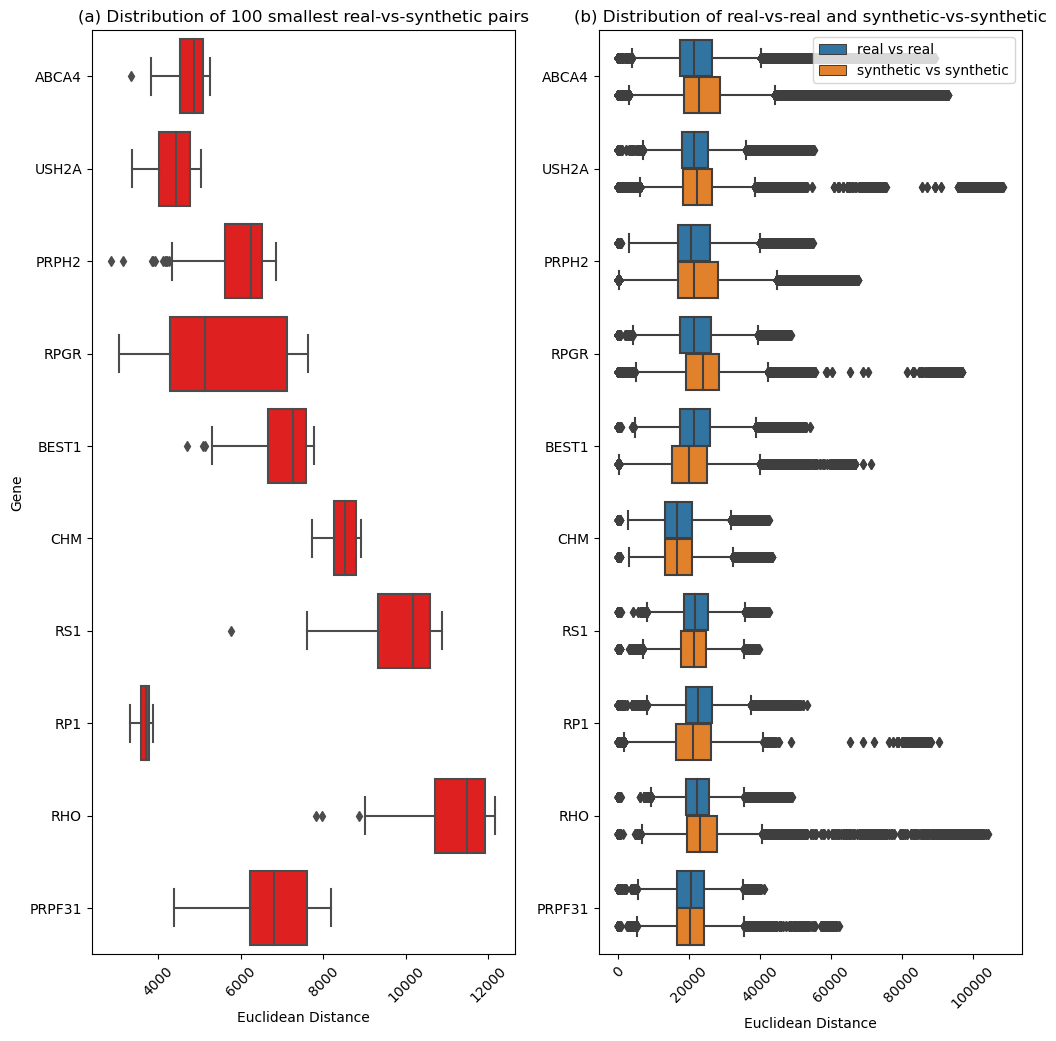

In [8]:
plt.figure(figsize=(12, 12))

plt.subplot(1,2,2)
ax = sns.boxplot(data=metrics[metrics.type.isin(["real_vs_real_euclidean", "synthetic_vs_synthetic_euclidean"])], y="gene", x="euclidean", order=classes, hue="type", hue_order=["real_vs_real_euclidean", "synthetic_vs_synthetic_euclidean"])
plt.ylabel("")
plt.xlabel("Euclidean Distance")
plt.xticks(rotation=45)
plt.title("(b) Distribution of real-vs-real and synthetic-vs-synthetic")
# plt.xlim(0, 140000)
h, l = ax.get_legend_handles_labels()
plt.legend(handles=h, labels=["real vs real", "synthetic vs synthetic"], loc="upper right")

plt.subplot(1, 2, 1)
sns.boxplot(data=top100, y="gene", x="euclidean", order=classes, color="red")
plt.ylabel("Gene")
plt.xlabel("Euclidean Distance")
plt.xticks(rotation=45)
plt.title("(a) Distribution of 100 smallest real-vs-synthetic pairs")
# plt.xlim(0, 140000)
# plt.suptitle("")

plt.show()
plt.close()

In [ ]:
# metrics.to_csv("/home/zchayav/projects/syntheye/quantitative_results/stylegan2_results/MSE_summary.csv", index=False)

## Quality Evaluation

In [ ]:
results_path = "/home/zchayav/projects/syntheye/quantitative_results/stylegan2_results/brisque_scores"
brisque_scores_path = os.listdir(results_path)

brisque_scores_synthetic = pd.DataFrame(columns=["gene", "Synthetic image path", "Quality Score"])
for path in brisque_scores_path:
    print(path)
    df = pd.read_csv(os.path.join(results_path, path), index_col="Unnamed: 0")
    df["gene"] = path.split("_")[0]
    brisque_scores_synthetic = brisque_scores_synthetic.append(df)
brisque_scores_synthetic["image_type"] = ["synthetic"]*len(brisque_scores_synthetic)
brisque_scores_synthetic.rename(columns={"gene":"gene", "Synthetic image path": "file.path", "Quality Score": "brisq.score"}, inplace=True)
brisque_scores_synthetic.reset_index(inplace=True, drop=True)

In [ ]:
brisque_scores_synthetic

In [ ]:
real_results_path = "/home/zchayav/projects/syntheye/datasets/eye2gene_new_filepaths/all_baf_valid_50deg_filtered_train_0_edited.csv"
real_df = pd.read_csv(real_results_path)
real_df = real_df[real_df.fold != -1]
real_df = real_df[["gene", "file.path", "brisq.score"]]
real_df["image_type"] = ["real"]*len(real_df)
real_df.reset_index(drop=True, inplace=True)

In [ ]:
from brisque import BRISQUE
from tqdm import tqdm
import numpy as np
from PIL import Image
brisq = BRISQUE()

# modify brisq values
new_brisq = np.zeros(len(real_df))
for i, row in tqdm(real_df.iterrows()):
    img = Image.open(row["file.path"])
    img = img.resize((512, 512))
    new_brisq[i] = brisq.get_score(np.array(img))
    
real_df["brisq.score"] = np.array(new_brisq)

In [ ]:
real_df.to_csv("/home/zchayav/projects/syntheye/quantitative_results/stylegan2_results/brisque_scores/real_imgs_brisque.csv", index=False)

## Plot distribution of scores

In [ ]:
combined_df = pd.concat([brisque_scores_synthetic, real_df], axis=0)
combined_df

In [ ]:
with open("../classes.txt") as f:
    classes = f.read().splitlines()

plt.figure(figsize=(6, 6))
sns.boxplot(data=combined_df, y="brisq.score", x="image_type", order=["real", "synthetic"])
# plt.xticks(rotation=45)
plt.xlabel("Image Type")
plt.ylabel("BRISQUE Score")
plt.title("BRISQUE scores of Synthetic vs Real images")
plt.show()

## Retraining Results

In [ ]:
simple_df

In [ ]:
inception_accuracies = [0.5751, 0.5199, 0.4108, 0.3861, 0.4627, 0.4219, 0.5011, 0.4829, 0.5737, 0.5211, 0.5767, 0.5205, 0.5868, 0.5108]
densenet_accuracies = [0.6058, 0.4221, 0.4514, 0.5242, 0.5983, 0.5925, 0.5795, 0.5187, 0.4209, 0.4302, 0.4799, 0.5098, 0.5039, 0.5045]
simple_accuracies = [0.3275, 0.2773, 0.2076, 0.1935, 0.1585, 0.2084, 0.1795, 0.1466, 0.3323, 0.2759, 0.3240, 0.2860, 0.2923, 0.2296]
dataset_types = ["R", "1800S", "3600S", "10800S", "R1800S", "R3600S", "RB"]
regimes = [1, 2]
columns=["Dataset Type", "Training Regime", "Accuracy"]
inception_df = pd.DataFrame(columns=columns)
simple_df = pd.DataFrame(columns=columns)
densenet_df = pd.DataFrame(columns=columns)

i = 0
for d in dataset_types:
    for r in regimes:
        df1 = pd.DataFrame([[d, r, simple_accuracies[i]]], columns=columns)
        simple_df = pd.concat([simple_df, df1])
        i += 1
simple_df = simple_df.reset_index()

plt.figure(figsize=(6, 12))

plt.subplot(2, 1, 1)
sns.barplot(data=simple_df, y="Dataset Type", x="Accuracy", hue="Training Regime", order=["1800S", "3600S", "10800S", "R", "R1800S", "R3600S", "RB"])
plt.legend(title="Regime", loc='upper right')
plt.title("(a) Multiclass Perceptron Model")
plt.xlim(0, 1)
plt.axvline(x=0.3275, color="red", linestyle="--", label="Model accuracy on real data only - Regime 1")
plt.axvline(x=0.2773, color="green", linestyle="--", label="Model accuracy on real data only - Regime 2")
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

# i = 0
# for d in dataset_types:
#     for r in regimes:
#         df1 = pd.DataFrame([[d, r, densenet_accuracies[i]]], columns=columns)
#         densenet_df = pd.concat([densenet_df, df1])
#         i += 1
# densenet_df = densenet_df.reset_index()

# plt.subplot(3, 1, 2)
# sns.barplot(data=densenet_df, y="Dataset Type", x="Accuracy", hue="Training Regime")
# plt.legend(title="Regime", loc='upper right')
# plt.title("DenseNet-169 Model")

i = 0
for d in dataset_types:
    for r in regimes:
        df1 = pd.DataFrame([[d, r, inception_accuracies[i]]], columns=columns)
        inception_df = pd.concat([inception_df, df1])
        i += 1
inception_df = inception_df.reset_index()

plt.subplot(2, 1, 2)
sns.barplot(data=inception_df, y="Dataset Type", x="Accuracy", hue="Training Regime", order=["1800S", "3600S", "10800S", "R", "R1800S", "R3600S", "RB"],)
# plt.legend(title="Regime", loc='upper right')
plt.title("(a) InceptionV3 model")
plt.axvline(x=0.5751, color="red", linestyle="--", label="Model accuracy on real data only - Regime 1")
plt.axvline(x=0.5199, color="green", linestyle="--", label="Model accuracy on real data only - Regime 2")
plt.xlim(0, 1)

plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', labels=["Model accuracy 1", "Model Accuracy 2", "Regime 1", "Regime 2"])
plt.show()